# ECE 189 Project Template

In [312]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy
from data_loader import *
from utils import *
from tqdm import tqdm

# Load data
data = JRDataset("MATLAB/JR_2015-12-04_truncated2.mat")

Look at the structure of the data

In [313]:
data[0]

trialNum: 420
startDateNum: 736302.5690227315
startDateStr: '2015-12-04 13:39:23'
timeTargetOn: 21
timeTargetAcquire: 362
timeTargetHeld: 862
timeTrialEnd: 882
subject: 'JenkinsC'
counter: np.ndarray with shape (1, 901) float32
state: np.ndarray with shape (1, 901) float32
cursorPos: np.ndarray with shape (3, 901) float32
spikeRaster: <96x901 sparse matrix of type '<class 'numpy.float64'>'
	with 1153 stored elements in Compressed Sparse Column format>
spikeRaster2: <96x901 sparse matrix of type '<class 'numpy.float64'>'
	with 872 stored elements in Compressed Sparse Column format>
isSuccessful: 1
timeFirstTargetAcquire: 362
timeLastTargetAcquire: 362
trialLength: 862
target: array([  0.,   0., -70.])

In [314]:
data[0].target

array([  0.,   0., -70.])

Plot all targets

Text(0, 0.5, 'y-position (mm)')

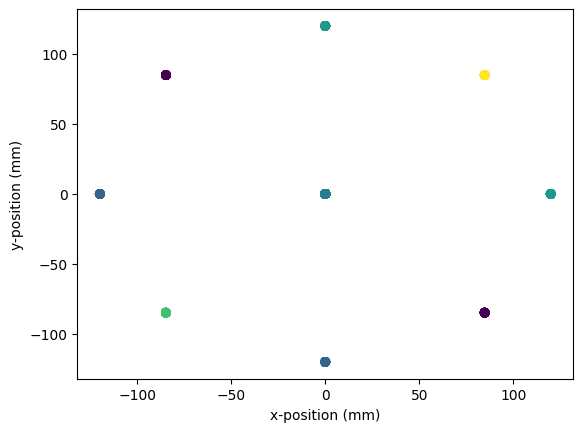

In [315]:
# to get along the x axis use data.target[:, 0], similarly for y axis use data.target[:, 1]
# color by frequency of x axis
plt.scatter(data.target[:, 0], data.target[:, 1], marker='o', c=((15 + data.target[:, 0])*(15 + (data.target[:, 1]))))
plt.xlabel('x-position (mm)')
plt.ylabel('y-position (mm)')

In [316]:
# Unique x values
print(np.unique(data.target[:, 0]))
# Unique y values
print(np.unique(data.target[:, 1]))

[-120.    -84.85    0.     84.85  120.  ]
[-120.    -84.85    0.     84.85  120.  ]


In [317]:
print(len(data))
print(np.sum(data.isSuccessful))

506
506


## Cursor Movements

In [318]:
data[0].cursorPos[:, 0]

array([ 81.97,  89.79, -70.  ], dtype=float32)

In [319]:
data[0].cursorPos[0:2, 1:30]

array([[81.97, 81.97, 81.97, 81.97, 81.97, 81.97, 81.97, 81.97, 81.97,
        81.97, 81.52, 81.52, 81.52, 81.52, 81.52, 81.52, 81.52, 81.52,
        81.52, 81.52, 81.52, 81.52, 81.52, 81.52, 81.52, 81.52, 80.91,
        80.91, 80.91],
       [89.79, 89.79, 89.79, 89.79, 89.79, 89.79, 89.79, 89.79, 89.79,
        89.79, 89.57, 89.57, 89.57, 89.57, 89.57, 89.57, 89.57, 89.57,
        89.57, 89.57, 89.57, 89.57, 89.57, 89.57, 89.57, 89.57, 89.21,
        89.21, 89.21]], dtype=float32)

Text(0, 0.5, 'y-position (mm)')

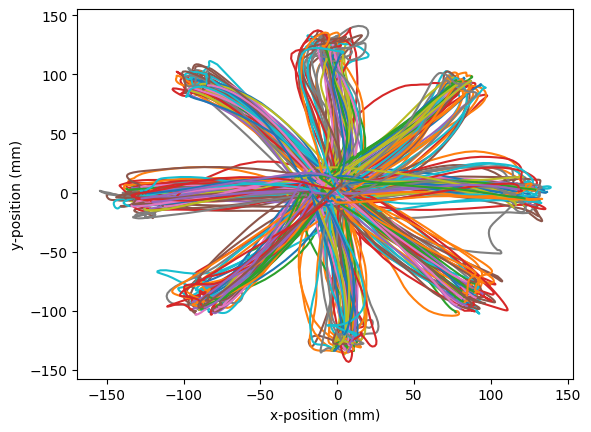

In [320]:
for i in range(len(data)):
    plt.plot(data[i].cursorPos[0], data[i].cursorPos[1])

plt.xlabel('x-position (mm)')
plt.ylabel('y-position (mm)')

Kinematics

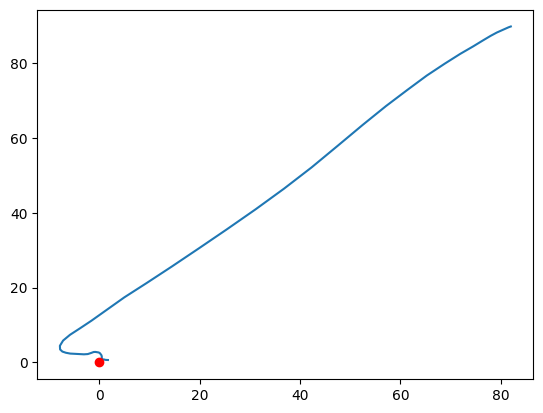

In [321]:
trial = 0
# Plot one trial
plt.plot(data[trial].cursorPos[0], data[trial].cursorPos[1])
# plot the target
plt.plot(data[trial].target[0], data[trial].target[1], 'ro')
plt.show()

Text(0, 0.5, 'Neuron #')

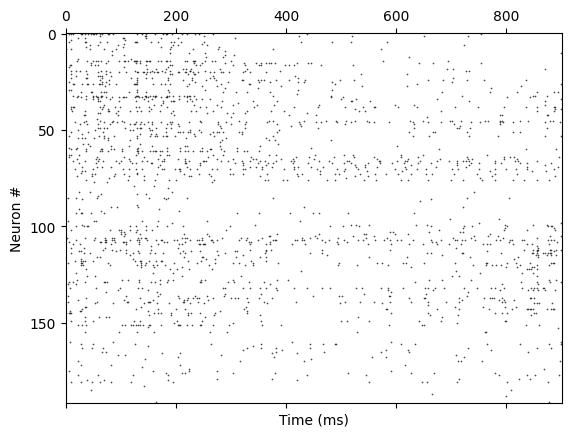

In [322]:
from scipy.sparse import vstack

spikes = [vstack((data[i].spikeRaster, data[i].spikeRaster2)) for i in range(len(data))]

plt.spy(spikes[0], markersize=0.2, aspect='auto', color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')

In [323]:
# train test split
# train_data = data[:int(len(data)*0.6)]
# test_data = data[int(len(data)*0.6):]
train_data = data[:400]
test_data = data[400:]

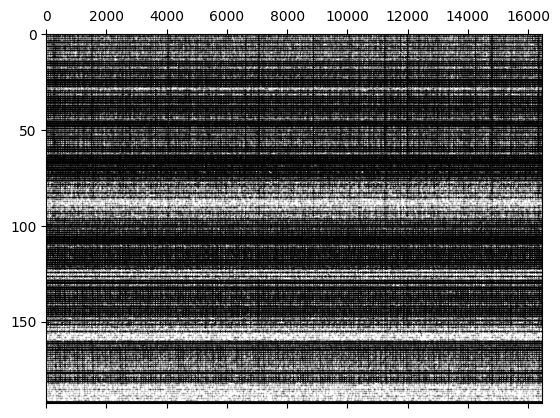

In [324]:
dt = 25
# horizontally stack the spike rasters
Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Y_bin = window_bin(Y, dt, 'sum')
Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
plt.spy(Y_bin, markersize=0.05, aspect='auto', color='black')
# plt.imshow(Y_bin, aspect='auto', cmap='gray')

In [325]:
# dt = 25
X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt

In [326]:
print(X_bin.shape)
print(Y_bin.shape)

(2, 16465)
(193, 16465)


In [327]:
L = X_bin @ np.linalg.pinv(Y_bin)

# dt = 25
decodedPositions = []
for i in range(len(test_data)):
    # Get the new neural data we want to decode
    Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
    Ytest_bin = window_bin(Ytest, dt, 'sum')
    Ytest_bin = np.vstack((Ytest_bin, np.ones((1, Ytest_bin.shape[1]))))
    # Decode the new neural data
    Xtest_bin = L @ Ytest_bin
    # Add the decoded positions to a list
    trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
    for j in range(Xtest_bin.shape[1]):
        trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)

    # Add the decoded positions to the list of all decoded positions
    decodedPositions.append(trialDecodedPositions)

In [328]:
len(decodedPositions)

106

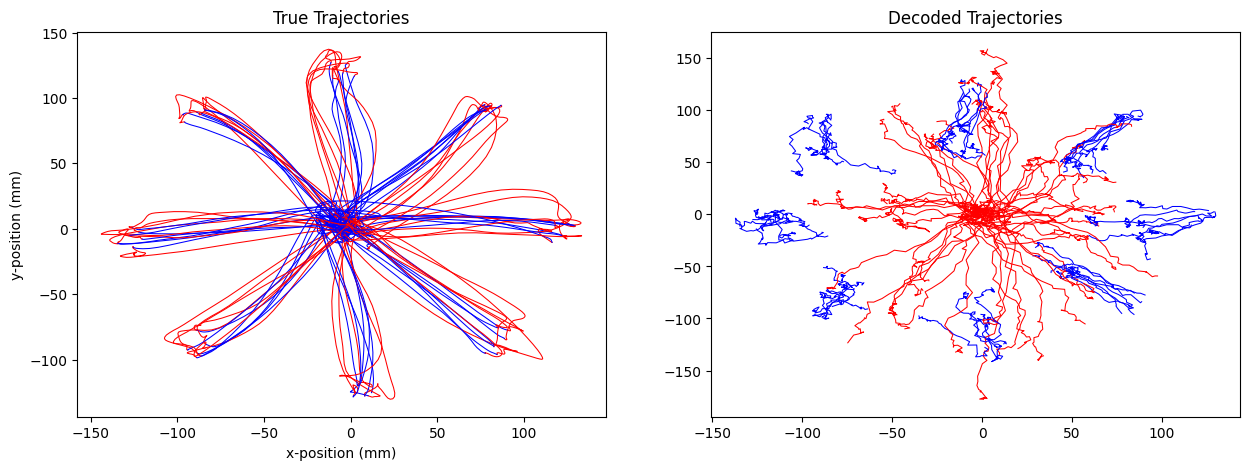

In [329]:
# Plot the decoded positions
# make subplots for true and decoded
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(test_data)):
    isCenterBack = np.abs(np.abs(test_data[i].target[0]) + np.abs(test_data[i].target[1])) < 1e-5
    plotColor = 'blue' if isCenterBack else 'red'
    # plot the true trajectories
    axs[0].plot(test_data[i].cursorPos[0], test_data[i].cursorPos[1], color=plotColor, linewidth=0.75)
    axs[1].plot(np.array(decodedPositions[i])[:, 0], np.array(decodedPositions[i])[:, 1], color=plotColor, linewidth=0.75)
    # set titles and labels
    axs[0].set_title('True Trajectories')
    axs[1].set_title('Decoded Trajectories')
    axs[0].set_xlabel('x-position (mm)')
    axs[0].set_ylabel('y-position (mm)')

In [330]:
# Calculate the MSE
# dt = 25
mses = []
for i in range(len(test_data)):
    # get true trajectories
    trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
    decodedTrajectories = np.array(decodedPositions[i]).T

    # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
    decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]

    # Calculate the MSE
    mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))

mse = np.mean(mses)
print("MSE: ", mse)

MSE:  3492.556006047366


## Trying other features

#### Data Exploring

In [331]:
Y_bin.shape

(193, 16465)

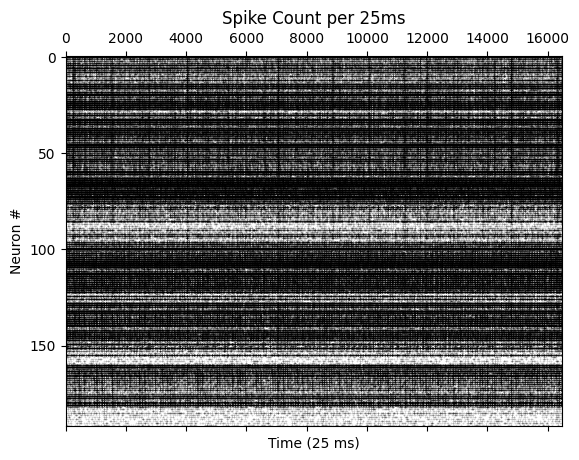

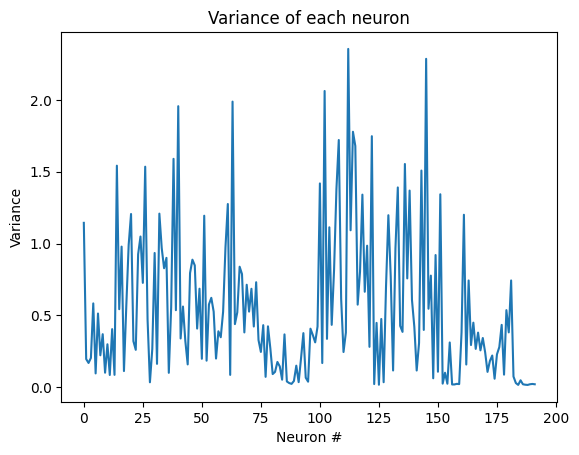

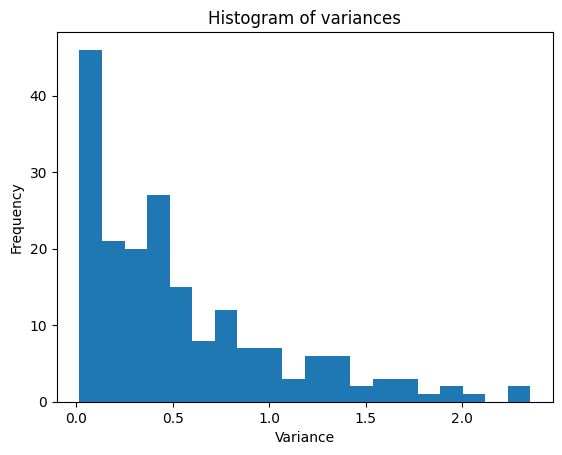

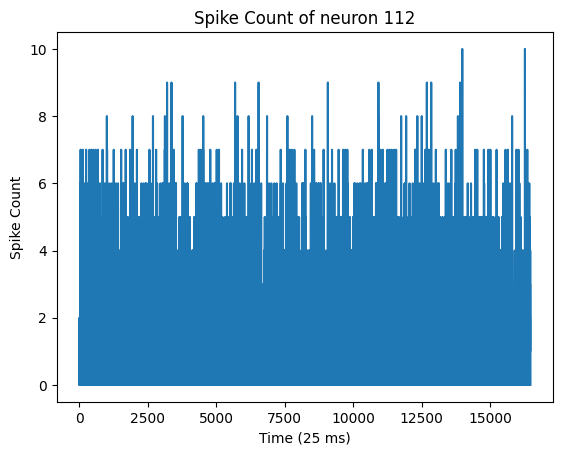

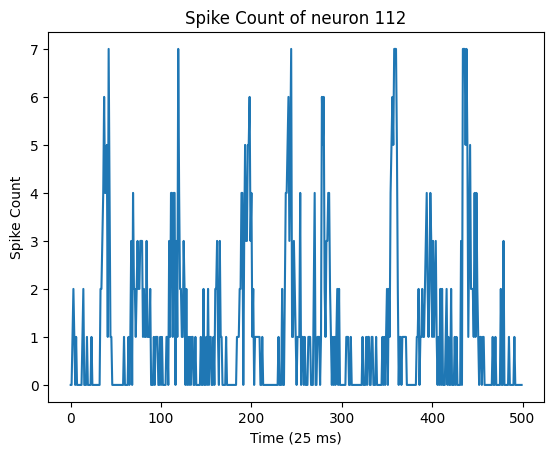

In [332]:
# Y_bin Spike count per 25ms
Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Y_bin = window_bin(Y, dt, 'sum')
plt.spy(Y_bin, markersize=0.05, aspect='auto', color='black')
plt.xlabel('Time (25 ms)')
plt.ylabel('Neuron #')
plt.title('Spike Count per 25ms')
plt.show()

# get the variance of each neuron and plot that
variances = np.var(Y_bin, axis=1)
plt.plot(variances)
plt.xlabel('Neuron #')
plt.ylabel('Variance')
plt.title('Variance of each neuron')
plt.show()

# plot the histogram of the variances
plt.hist(variances, bins=20)
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of variances')
plt.show()

# plot the spike rate of the neuron with the highest variance
plt.plot(Y_bin[np.argmax(variances), :])
plt.xlabel('Time (25 ms)')
plt.ylabel('Spike Count')
plt.title(f'Spike Count of neuron {np.argmax(variances)}')
plt.show()

# show the first 50 samples of the spike raster of the neuron with the highest variance
plt.plot(Y_bin[np.argmax(variances), :500])
plt.xlabel('Time (25 ms)')
plt.ylabel('Spike Count')
plt.title(f'Spike Count of neuron {np.argmax(variances)}')
plt.show()


#### Neuron Filtering

In [333]:
# ? That was embarrassing, lets pretend that never happened lol


# # Lets repeat the same process we did earlier but this time lets only include some neurons as a hyperparameter
# ratios = np.linspace(0, 1, 50)[1:-1]
# mse_results = []
# for ratio in tqdm(ratios):
#     ratioNeurons = ratio
#     Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
#     Y_bin = window_bin(Y, dt, 'sum')
#     Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
#     # get the variance of each neuron
#     variances = np.var(Y_bin, axis=1)
#     # get the top ratioNeurons neurons
#     topNeurons = np.argsort(variances)[-int(ratioNeurons * len(variances)):]
#     Y_top = Y_bin[topNeurons, :]
#     Y_top = np.vstack((Y_top, np.ones((1, Y_top.shape[1]))))
#     # bin the cursor positions and differentiate them to get velocity
#     X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
#     X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
#     # get the top neurons
#     L = X_bin @ np.linalg.pinv(Y_top)
#     print(L.shape)
#     # dt = 25
#     decodedPositions = []
#     mses = []
#     fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#     for i in range(len(test_data)):
#         # Get the new neural data we want to decode
#         Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
#         Ytest_bin = window_bin(Ytest, dt, 'sum')
#         Y_top = Ytest_bin[topNeurons, :]
#         Ytest_bin = np.vstack((Y_top, np.ones((1, Y_top.shape[1]))))
#         # Decode the new neural data
#         Xtest_bin = L @ Ytest_bin
#         # Add the decoded positions to a list
#         trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
#         for j in range(Xtest_bin.shape[1]):
#             trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)
#         # Add the decoded positions to the list of all decoded positions
#         decodedPositions.append(trialDecodedPositions)
#         # Plot the decoded positions
#         # make subplots for true and decoded
#         isCenterBack = np.abs(np.abs(test_data[i].target[0]) + np.abs(test_data[i].target[1])) < 1e-5
#         plotColor = 'blue' if isCenterBack else 'red'
#         # plot the true trajectories
#         axs[0].plot(test_data[i].cursorPos[0], test_data[i].cursorPos[1], color=plotColor, linewidth=0.75)
#         axs[1].plot(np.array(decodedPositions[i])[:, 0], np.array(decodedPositions[i])[:, 1], color=plotColor, linewidth=0.75)
#         # set titles and labels
#         axs[0].set_title('True Trajectories')
#         axs[1].set_title('Decoded Trajectories')
#         axs[0].set_xlabel('x-position (mm)')
#         axs[0].set_ylabel('y-position (mm)')
#         # Calculate the MSE
#         # get true trajectories
#         trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
#         decodedTrajectories = np.array(decodedPositions[i]).T
#         # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
#         decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]
#         # Calculate the MSE
#         mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))
#     mse = np.mean(mses)
#     # print("MSE: ", mse)
#     mse_results.append(mse)

# plt.plot(ratios, mse_results)
# plt.xlabel('Ratio of neurons')
# plt.ylabel('MSE')
# plt.title('MSE vs Ratio of neurons')
# plt.show()

#### Low Pass Filtering

In [334]:
# create a gaussian filter in the time domain, and convert it to the frequency domain
def gaussian_filter(size, sigma):
    # create a 1d array of size size
    x = np.arange(0, size, 1, float)
    # center the gaussian at the middle
    x = x - (size - 1) / 2.0
    # apply the gaussian formula
    g = np.exp(-x**2 / (2 * sigma**2))
    # normalize the gaussian
    g = g / np.sum(g)
    # send it to the frequency domain
    g = np.fft.fft(g)
    return np.abs(g)


Text(0, 0.5, 'Amplitude')

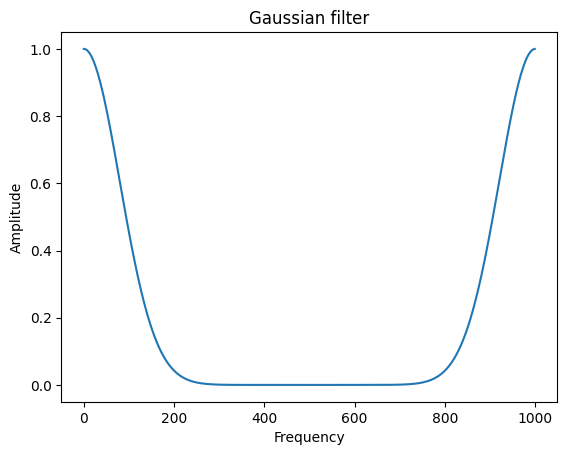

In [335]:
plt.plot(gaussian_filter(1000, 2))
plt.title('Gaussian filter')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

In [336]:
# Rect Filter:
def rect_filter(size, width):
    # create a 1d array of size size
    x = np.ones(size)
    # center the rect at the middle
    x[int(size/2-width/2):int(size/2+width/2)] = 0
    return np.abs(x)

Text(0, 0.5, 'Amplitude')

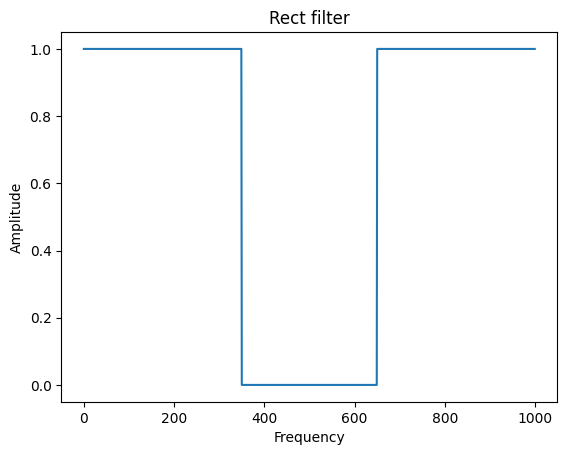

In [337]:
plt.plot(rect_filter(1000, 300))
plt.title('Rect filter')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

In [338]:
# Sin Filter:
def sinc_filter(size, things, o=2):
    i2 = np.zeros(size)
    i2[0 + o:things + 0] = 1
    fft = np.fft.fft(i2)
    return fft
        

C:\Users\sanji\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Amplitude')

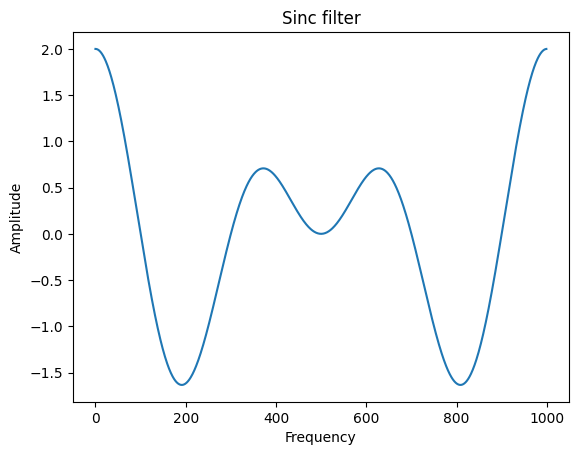

In [339]:
plt.plot(sinc_filter(1000, 4))
plt.title('Sinc filter')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:09<00:00,  5.35s/it]


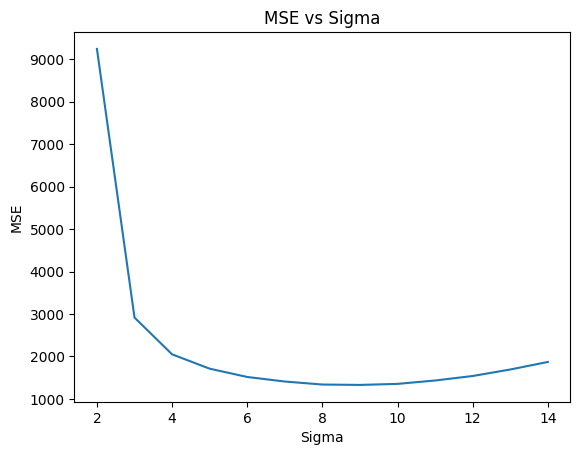

In [340]:
# Lets repeat the same process we did earlier but this time lets only include some neurons as a hyperparameter
# sigmas = np.linspace(1.5, 2.2, 10)
# sigmas = np.linspace(0.1, 5, 50)
sigmas = np.array(list(range(2, 15)))
mse_results = []
for things in tqdm(sigmas):
    Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
    Y_bin = window_bin(Y, dt, 'sum')
    # filter = gaussian_filter(Y_bin.shape[1], sigma)
    # filter = rect_filter(Y_bin.shape[1], width)
    filter = sinc_filter(Y_bin.shape[1], things)
    # apply the gaussian filter to each neuron
    for i in range(Y_bin.shape[0]):
        Y_bin[i, :] = np.fft.ifft(np.fft.fft(Y_bin[i, :]) * filter).real
    Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
    # bin the cursor positions and differentiate them to get velocity
    X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
    # Differentiate the cursor positions to get velocity
    X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
    L = X_bin @ np.linalg.pinv(Y_bin)
    # print(L.shape)
    # dt = 25
    decodedPositions = []
    mses = []
    # fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(len(test_data)):
        # Get the new neural data we want to decode
        Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
        Ytest_bin = window_bin(Ytest, dt, 'sum')
        # filter = gaussian_filter(Ytest_bin.shape[1], sigma)
        # filter = rect_filter(Ytest_bin.shape[1], width)
        filter = sinc_filter(Ytest_bin.shape[1], things)
        # apply the gaussian filter to each neuron
        for j in range(Ytest_bin.shape[0]):
            # Ytest_bin[j, :] = np.fft.ifft(np.fft.fft(Ytest_bin[j, :]) * gaussian_filter(Ytest_bin.shape[1], sigma)).real
            # Ytest_bin[j, :] = np.fft.ifft(np.fft.fft(Ytest_bin[j, :]) * rect_filter(Ytest_bin.shape[1], width)).real
            Ytest_bin[j, :] = np.fft.ifft(np.fft.fft(Ytest_bin[j, :]) * sinc_filter(Ytest_bin.shape[1], things)).real
        Ytest_bin = np.vstack((Ytest_bin, np.ones((1, Ytest_bin.shape[1]))))
        # Decode the new neural data
        Xtest_bin = L @ Ytest_bin
        # Add the decoded positions to a list
        trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
        for j in range(Xtest_bin.shape[1]):
            trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)
        # Add the decoded positions to the list of all decoded positions
        decodedPositions.append(trialDecodedPositions)
        # Plot the decoded positions
        # Calculate the MSE
        # get true trajectories
        trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
        decodedTrajectories = np.array(decodedPositions[i]).T
        # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
        decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]
        # Calculate the MSE
        mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))
    mse = np.mean(mses)
    # print("MSE: ", mse)
    mse_results.append(mse)
plt.show()
plt.plot(sigmas, mse_results)
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.title('MSE vs Sigma')
plt.show()

In [341]:
min(mse_results)

1330.3666307192348

#### Use the data from the filtered neurons to create the features

MSE:  1330.3666307192348


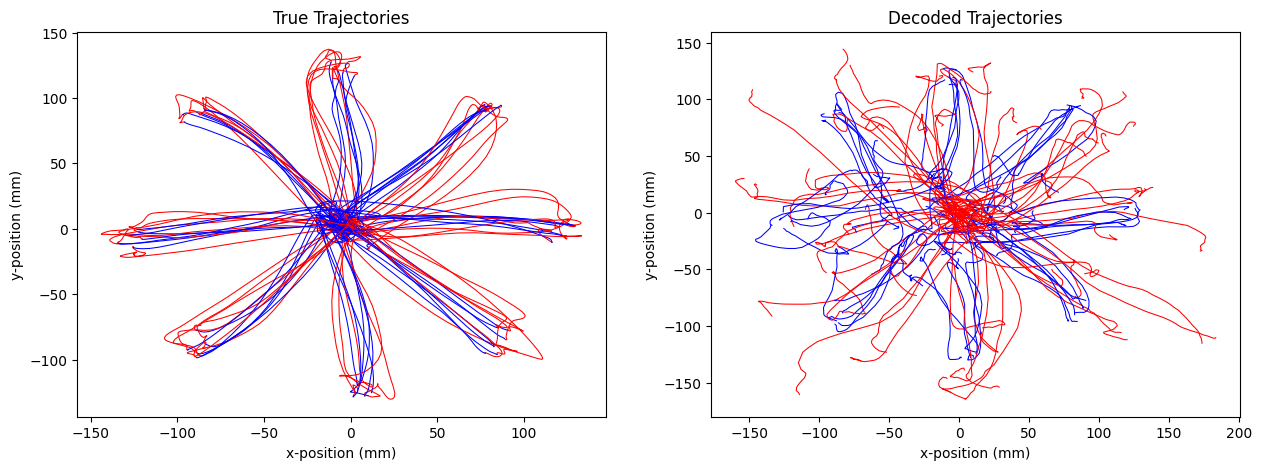

In [342]:
# assign sigma to the best value and then plot the decoded trajectories
sigma = sigmas[np.argmin(mse_results)]
# lp_sigma = sigma
lp_thing = sigma
Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Y_bin = window_bin(Y, dt, 'sum')
# apply the gaussian filter to each neuron
# filter = gaussian_filter(Y_bin.shape[1], sigma)
filter = sinc_filter(Y_bin.shape[1], lp_thing)
for i in range(Y_bin.shape[0]):
    Y_bin[i, :] = np.fft.ifft(np.fft.fft(Y_bin[i, :]) * filter).real
Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
# bin the cursor positions and differentiate them to get velocity
X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
# Differentiate the cursor positions to get velocity
X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
L = X_bin @ np.linalg.pinv(Y_bin)
decodedPositions = []
mses = []
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(test_data)):
    # Get the new neural data we want to decode
    Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
    Ytest_bin = window_bin(Ytest, dt, 'sum')
    # filter = gaussian_filter(Ytest_bin.shape[1], sigma)
    filter = sinc_filter(Ytest_bin.shape[1], lp_thing)
    # apply the gaussian filter to each neuron
    for j in range(Ytest_bin.shape[0]):
        Ytest_bin[j, :] = np.fft.ifft(np.fft.fft(Ytest_bin[j, :]) * filter).real
    Ytest_bin = np.vstack((Ytest_bin, np.ones((1, Ytest_bin.shape[1]))))
    # Decode the new neural data
    Xtest_bin = L @ Ytest_bin
    # Add the decoded positions to a list
    trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
    for j in range(Xtest_bin.shape[1]):
        trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)
    # Add the decoded positions to the list of all decoded positions
    decodedPositions.append(trialDecodedPositions)
    # Plot the decoded positions
    isCenterBack = np.abs(np.abs(test_data[i].target[0]) + np.abs(test_data[i].target[1])) < 1e-5
    plotColor = 'blue' if isCenterBack else 'red'
    # plot the true trajectories
    axs[0].plot(test_data[i].cursorPos[0], test_data[i].cursorPos[1], color=plotColor, linewidth=0.75)
    axs[1].plot(np.array(decodedPositions[i])[:, 0], np.array(decodedPositions[i])[:, 1], color=plotColor, linewidth=0.75)
    # set titles and labels
    axs[0].set_title('True Trajectories')
    axs[1].set_title('Decoded Trajectories')
    axs[0].set_xlabel('x-position (mm)')
    axs[0].set_ylabel('y-position (mm)')
    axs[1].set_xlabel('x-position (mm)')
    axs[1].set_ylabel('y-position (mm)')
    # Calculate the MSE
    # get true trajectories
    trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
    decodedTrajectories = np.array(decodedPositions[i]).T
    # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
    decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]
    # Calculate the MSE
    mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))

mse = np.mean(mses)
print("MSE: ", mse)

#### High Pass Filtering

In [343]:
# the high pass filter is 1 - low pass filter
def high_pass_filter(size, width):
    h = np.zeros(size)
    h[int(size/2-width/2):int(size/2+width/2)] = 1
    return h

Text(0, 0.5, 'Amplitude')

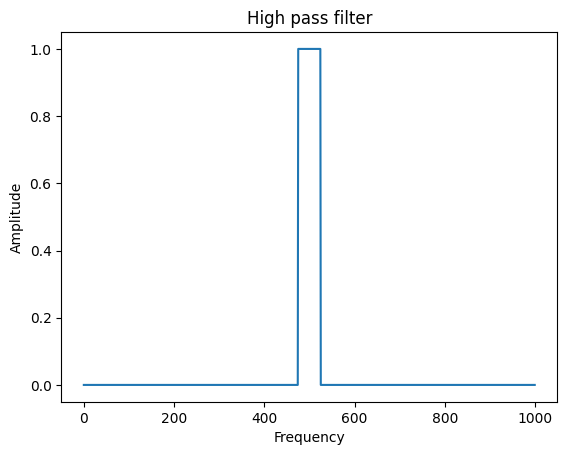

In [344]:
plt.plot(high_pass_filter(1000, 50))
plt.title('High pass filter')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


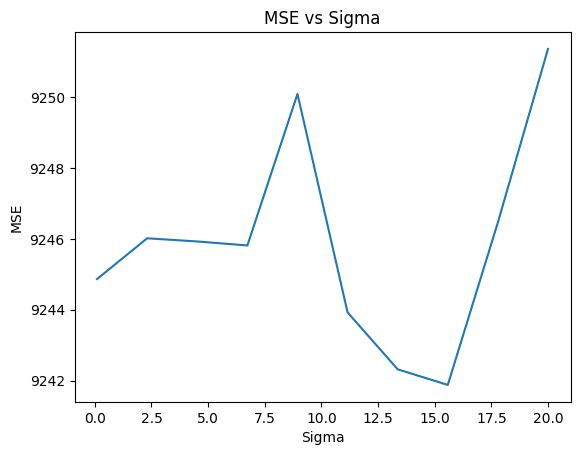

In [345]:
# Now for high pass
# sigmas = np.array(list(range(1, 15)))
sigmas = np.linspace(0.1, 20, 10)
mse_results = []
for sigma in tqdm(sigmas):
    Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
    Y_bin = window_bin(Y, dt, 'sum')
    # apply the gaussian filter to each neuron
    filter = high_pass_filter(Y_bin.shape[1], sigma)
    for i in range(Y_bin.shape[0]):
        Y_bin[i, :] = np.fft.ifft(np.fft.fft(Y_bin[i, :]) * filter).real
    Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
    # bin the cursor positions and differentiate them to get velocity
    X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
    # Differentiate the cursor positions to get velocity
    X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
    # get the top neurons
    L = X_bin @ np.linalg.pinv(Y_bin)
    # print(L.shape)
    # dt = 25
    decodedPositions = []
    mses = []
    for i in range(len(test_data)):
        # Get the new neural data we want to decode
        Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
        Ytest_bin = window_bin(Ytest, dt, 'sum')
        # apply the gaussian filter to each neuron
        filter = high_pass_filter(Ytest_bin.shape[1], sigma)
        for j in range(Ytest_bin.shape[0]):
            Ytest_bin[j, :] = np.fft.ifft(np.fft.fft(Ytest_bin[j, :]) * filter).real
        Ytest_bin = np.vstack((Ytest_bin, np.ones((1, Ytest_bin.shape[1]))))
        # Decode the new neural data
        Xtest_bin = L @ Ytest_bin
        # Add the decoded positions to a list
        trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
        for j in range(Xtest_bin.shape[1]):
            trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)
        # Add the decoded positions to the list of all decoded positions
        decodedPositions.append(trialDecodedPositions)
        # Calculate the MSE
        # get true trajectories
        trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
        decodedTrajectories = np.array(decodedPositions[i]).T
        # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
        decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]
        # Calculate the MSE
        mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))
    mse = np.mean(mses)
    # print("MSE: ", mse)
    mse_results.append(mse)
plt.show()
plt.plot(sigmas, mse_results)
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.title('MSE vs Sigma')
plt.show()

In [346]:
np.min(mse_results)

9241.876087829321

MSE:  9241.876087829321


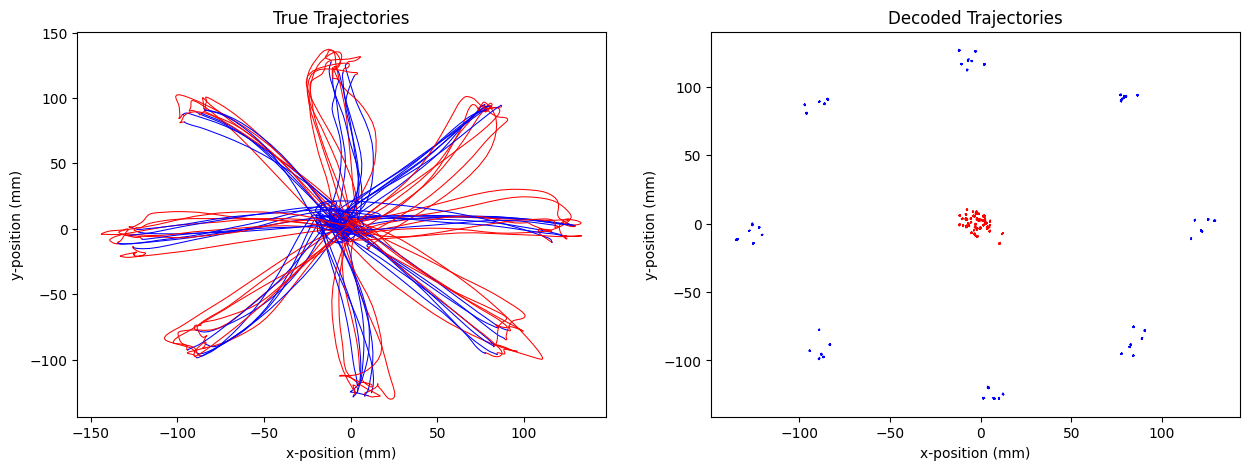

In [347]:
# assign sigma to the best value and then plot the decoded trajectories
sigma = sigmas[np.argmin(mse_results)]
# lp_sigma = sigma
lp_thing = sigma
Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Y_bin = window_bin(Y, dt, 'sum')
# apply the gaussian filter to each neuron
# filter = gaussian_filter(Y_bin.shape[1], sigma)
filter = high_pass_filter(Y_bin.shape[1], lp_thing)
for i in range(Y_bin.shape[0]):
    Y_bin[i, :] = np.fft.ifft(np.fft.fft(Y_bin[i, :]) * filter).real
Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
# bin the cursor positions and differentiate them to get velocity
X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
# Differentiate the cursor positions to get velocity
X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
L = X_bin @ np.linalg.pinv(Y_bin)
decodedPositions = []
mses = []
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(test_data)):
    # Get the new neural data we want to decode
    Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
    Ytest_bin = window_bin(Ytest, dt, 'sum')
    # filter = gaussian_filter(Ytest_bin.shape[1], sigma)
    filter = high_pass_filter(Ytest_bin.shape[1], lp_thing)
    # apply the gaussian filter to each neuron
    for j in range(Ytest_bin.shape[0]):
        Ytest_bin[j, :] = np.fft.ifft(np.fft.fft(Ytest_bin[j, :]) * filter).real
    Ytest_bin = np.vstack((Ytest_bin, np.ones((1, Ytest_bin.shape[1]))))
    # Decode the new neural data
    Xtest_bin = L @ Ytest_bin
    # Add the decoded positions to a list
    trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
    for j in range(Xtest_bin.shape[1]):
        trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)
    # Add the decoded positions to the list of all decoded positions
    decodedPositions.append(trialDecodedPositions)
    # Plot the decoded positions
    isCenterBack = np.abs(np.abs(test_data[i].target[0]) + np.abs(test_data[i].target[1])) < 1e-5
    plotColor = 'blue' if isCenterBack else 'red'
    # plot the true trajectories
    axs[0].plot(test_data[i].cursorPos[0], test_data[i].cursorPos[1], color=plotColor, linewidth=0.75)
    axs[1].plot(np.array(decodedPositions[i])[:, 0], np.array(decodedPositions[i])[:, 1], color=plotColor, linewidth=0.75)
    # set titles and labels
    axs[0].set_title('True Trajectories')
    axs[1].set_title('Decoded Trajectories')
    axs[0].set_xlabel('x-position (mm)')
    axs[0].set_ylabel('y-position (mm)')
    axs[1].set_xlabel('x-position (mm)')
    axs[1].set_ylabel('y-position (mm)')
    # Calculate the MSE
    # get true trajectories
    trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
    decodedTrajectories = np.array(decodedPositions[i]).T
    # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
    decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]
    # Calculate the MSE
    mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))

mse = np.mean(mses)
print("MSE: ", mse)

#### Try fitting on the derivative of the data


(2, 16465)
MSE:  9208.26331875773


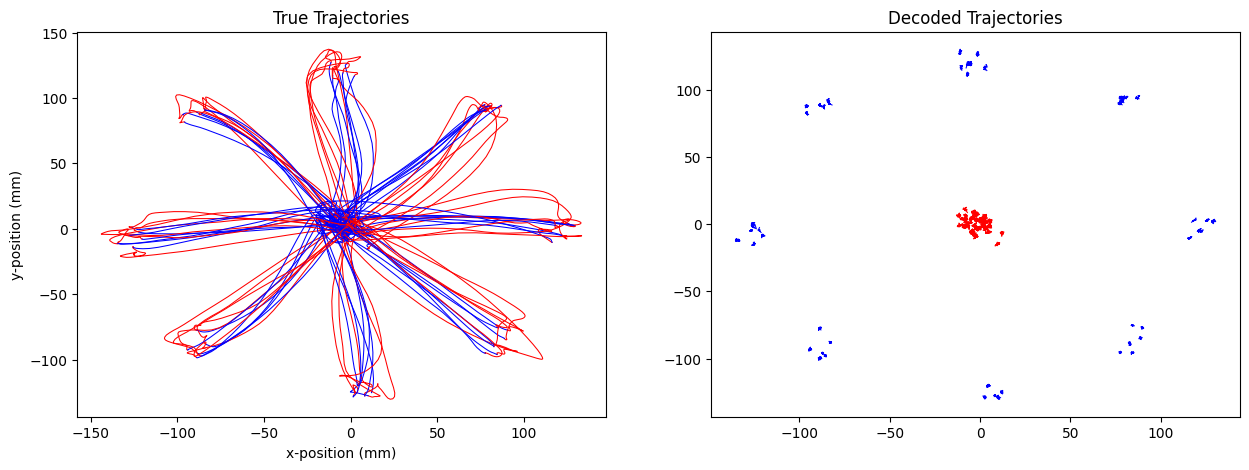

In [ ]:
Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Y_bin = window_bin(Y, dt, 'sum')
for i in range(Y_bin.shape[0]):
    # Take the derivative of every neuron in Y_bin
    Y_bin[i, :-1] = Y_bin[i, 1:] - Y_bin[i, 0:-1]
Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
# bin the cursor positions and differentiate them to get velocity
X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
# Differentiate the cursor positions to get velocity
X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
print(X_bin.shape)
# get the top neurons
L = X_bin @ np.linalg.pinv(Y_bin)
# print(L.shape)
# dt = 25
decodedPositions = []
mses = []
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(test_data)):
    # Get the new neural data we want to decode
    Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
    Ytest_bin = window_bin(Ytest, dt, 'sum')
    # apply the gaussian filter to each neuron
    for j in range(Ytest_bin.shape[0]):
        Ytest_bin[j, :-1] = Ytest_bin[j, 1:] - Ytest_bin[j, 0:-1]
    Ytest_bin = np.vstack((Ytest_bin, np.ones((1, Ytest_bin.shape[1]))))
    # Decode the new neural data
    Xtest_bin = L @ Ytest_bin
    # Add the decoded positions to a list
    trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
    for j in range(Xtest_bin.shape[1]):
        trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)
    # Add the decoded positions to the list of all decoded positions
    decodedPositions.append(trialDecodedPositions)
    # Plot the decoded positions
    # make subplots for true and decoded
    isCenterBack = np.abs(np.abs(test_data[i].target[0]) + np.abs(test_data[i].target[1])) < 1e-5
    plotColor = 'blue' if isCenterBack else 'red'
    # plot the true trajectories
    axs[0].plot(test_data[i].cursorPos[0], test_data[i].cursorPos[1], color=plotColor, linewidth=0.75)
    axs[1].plot(np.array(decodedPositions[i])[:, 0], np.array(decodedPositions[i])[:, 1], color=plotColor, linewidth=0.75)
    # set titles and labels
    axs[0].set_title('True Trajectories')
    axs[1].set_title('Decoded Trajectories')
    axs[0].set_xlabel('x-position (mm)')
    axs[0].set_ylabel('y-position (mm)')
    # Calculate the MSE
    # get true trajectories
    trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
    decodedTrajectories = np.array(decodedPositions[i]).T
    # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
    decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]
    # Calculate the MSE
    mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))
mse = np.mean(mses)
print("MSE: ", mse)

#### It is possible that the Neural signal can predict the angle and magnitude of the cursor movement rather than the x and y, so lets treat the outputs as such and see if that improves MSE.

(2, 16465)
MSE:  10249.294584841935


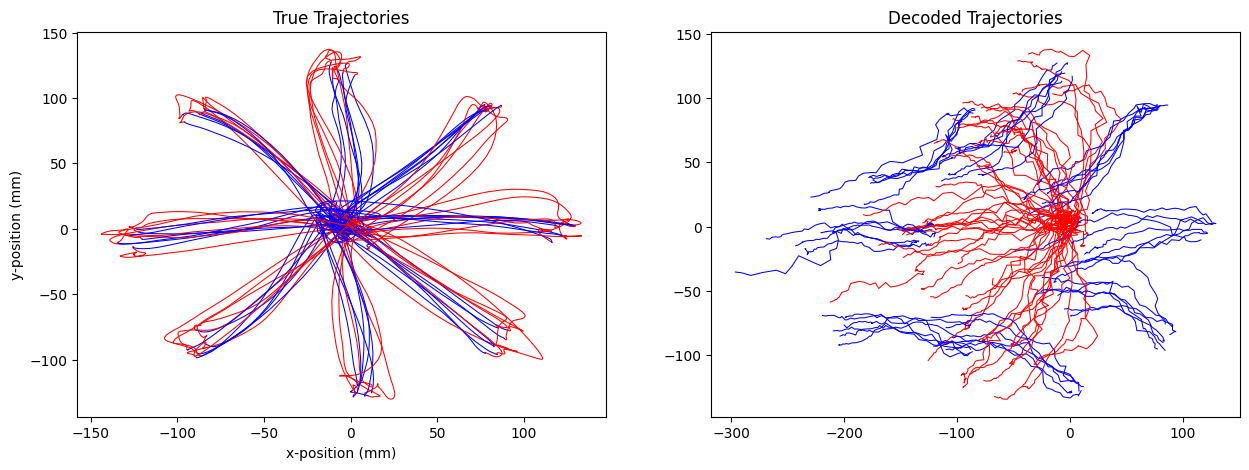

In [ ]:
Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Y_bin = window_bin(Y, dt, 'sum')
Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
# bin the cursor positions and differentiate them to get velocity
X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
# Differentiate the cursor positions to get velocity
X_bin = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
# So X_bin[0, :] is the x velocity and X_bin[1, :] is the y velocity
X_bin = np.vstack((np.sqrt(X_bin[0, :]**2 + X_bin[1, :]**2), np.arctan2(X_bin[1, :], X_bin[0, :])))
print(X_bin.shape)
# get the top neurons
L = X_bin @ np.linalg.pinv(Y_bin)
# print(L.shape)
# dt = 25
decodedPositions = []
mses = []
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(test_data)):
    # Get the new neural data we want to decode
    Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
    Ytest_bin = window_bin(Ytest, dt, 'sum')
    Ytest_bin = np.vstack((Ytest_bin, np.ones((1, Ytest_bin.shape[1]))))
    # Decode the new neural data
    Xtest_bin = L @ Ytest_bin
    # Convert it back to x and y velocities
    XX_fresh = -Xtest_bin[0, :] * np.cos(Xtest_bin[1, :])
    XY_fresh = Xtest_bin[0, :] * np.sin(Xtest_bin[1, :])
    Xtest_bin = np.vstack((XX_fresh, XY_fresh))
    # Add the decoded positions to a list
    trialDecodedPositions = [test_data[i].cursorPos[0:2, 0]]
    for j in range(Xtest_bin.shape[1]):
        trialDecodedPositions.append(trialDecodedPositions[-1] + Xtest_bin[0:2, j] * dt)
    # Add the decoded positions to the list of all decoded positions
    decodedPositions.append(trialDecodedPositions)
    # Plot the decoded positions
    # make subplots for true and decoded
    isCenterBack = np.abs(np.abs(test_data[i].target[0]) + np.abs(test_data[i].target[1])) < 1e-5
    plotColor = 'blue' if isCenterBack else 'red'
    # plot the true trajectories
    axs[0].plot(test_data[i].cursorPos[0], test_data[i].cursorPos[1], color=plotColor, linewidth=0.75)
    axs[1].plot(np.array(decodedPositions[i])[:, 0], np.array(decodedPositions[i])[:, 1], color=plotColor, linewidth=0.75)
    # set titles and labels
    axs[0].set_title('True Trajectories')
    axs[1].set_title('Decoded Trajectories')
    axs[0].set_xlabel('x-position (mm)')
    axs[0].set_ylabel('y-position (mm)')
    # Calculate the MSE
    # get true trajectories
    trueTrajectories = window_bin(test_data[i].cursorPos[:2], dt, 'first')
    decodedTrajectories = np.array(decodedPositions[i]).T
    # If the second dimension of decodedTrajectories is more than the second dimension of trueTrajectories, cap it
    decodedTrajectories = decodedTrajectories[:, :trueTrajectories.shape[1]]
    # Calculate the MSE
    mses.append(np.mean(np.sum((trueTrajectories - decodedTrajectories)**2, axis=0)))
mse = np.mean(mses)
print("MSE: ", mse)

Never mine I was wrong lol

#### Trying to use Kalman Filtering
Since this is a system with some dynamics, this is well suited for a Kalman Filter!!!
https://agamtomar.github.io/files/STATS_201C_Final_Paper.pdf

In [ ]:
# We want to use our linear predictor on the px py vx vy and a bias term
Y = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Y_bin = window_bin(Y, dt, 'sum')
Y_bin = np.vstack((Y_bin, np.ones((1, Y_bin.shape[1]))))
# bin the cursor positions and differentiate them to get velocity
X_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
X_pos = X_bin[0:2, :]
X_vel = (X_bin[0:2, 1:] - X_bin[0:2, 0:-1])/dt
X_dyn = np.vstack((X_pos, X_vel, np.ones((1, X_pos.shape[1])))) # (pos, vel, bias) -> (px, py, vx, vy, 1)

print(np.matmul(Xk[:,1:].astype('float'),scipy.linalg.pinv(Xk[:,:-1].astype('float'))))
# lets compute the covariance matrix of the dynamics
L = X_bin @ np.linalg.pinv(Y_bin)
# print(L.shape)
# dt = 25
decodedPositions = []
mses = []

# NN
Alright it is time to be 14 and deep.

In [ ]:
import random
import torch
from torch import nn
# Our inputs are the spikes with respect to time and our outputs are the cursor positions
class NNPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(NNPredictor, self).__init__()
        # we want to have 4 layers, 1 input layer, 2 hidden layers, and 1 output layer
        self.input_size = input_size
        self.output_size = output_size
        layers = []
        for i in range(2):
            layers.append(nn.Linear(input_size, input_size))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool1d(2))
            input_size = input_size // 2

        # Add a final linear layer
        layers.append(nn.Linear(input_size, output_size, bias=True))

        # Create the model
        self.model = nn.Sequential(*layers)


    def forward(self, x):
        for layer in self.model:
            # print(x.shape)
            x = layer(x)
        return x

In [ ]:
# train and test the model

model = NNPredictor(192, 2)
lossfn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Ytrain = scipy.sparse.vstack((train_data.stackedSpikeRaster, train_data.stackedSpikeRaster2))
Ytrain_bin = window_bin(Y, dt, 'sum')
# low pass filter the spikes
for i in range(Ytrain_bin.shape[0]):
    Ytrain_bin[i, :] = np.fft.ifft(np.fft.fft(Ytrain_bin[i, :]) * gaussian_filter(Ytrain_bin.shape[1], lp_sigma)).real
Xtrain_bin = window_bin(train_data.stackedCursorPos, dt, 'first')
Xtrain_bin = (Xtrain_bin[0:2, 1:] - Xtrain_bin[0:2, 0:-1])/dt

nn_train = scipy.sparse.vstack((Ytrain_bin, Xtrain_bin))

Ytest = scipy.sparse.vstack((test_data.stackedSpikeRaster, test_data.stackedSpikeRaster2))
Ytest_bin = window_bin(Ytest, dt, 'sum')
# low pass filter the spikes
for i in range(Ytest_bin.shape[0]):
    Ytest_bin[i, :] = np.fft.ifft(np.fft.fft(Ytest_bin[i, :]) * gaussian_filter(Ytest_bin.shape[1], lp_sigma)).real
Xtest_bin = window_bin(test_data.stackedCursorPos, dt, 'first')
Xtest_bin = (Xtest_bin[0:2, 1:] - Xtest_bin[0:2, 0:-1])/dt
nn_test = scipy.sparse.vstack((Ytest_bin, Xtest_bin))

# train the model
epochs = 15
train_losses = []
test_losses = []
for i in tqdm(range(epochs)):
    # nn_train.shape[1] is the number of samples
    # lets shuffle and split the data into batches
    shuffled_indices = list(range(nn_train.shape[1]))
    random.shuffle(shuffled_indices)
    shuffled_indices = np.array(shuffled_indices)
    batch_size = 2**10
    for j in (range(0, nn_train.shape[1], batch_size)):
        # get the batch
        batch_indices = shuffled_indices[j:(j+batch_size) if (j+batch_size) < nn_train.shape[1] else nn_train.shape[1]]
        batch = nn_train.tocsr()[:, batch_indices]
        # print(batch[0:-2, :].shape)
        # print(batch[-2:, :].shape)
        # get the spikes
        spikes = torch.tensor(batch[0:-2, :].toarray().astype('float32'))
        # get the cursor positions
        cursorPos = torch.tensor(batch[-2:, :].toarray().astype('float32'))
        # pass the spikes through the model
        output = model(spikes.T)
        # print(output.shape)
        # print(cursorPos.shape)
        loss = lossfn(output, cursorPos.T)
        # backpropagate
        loss.backward()
        # update the weights
        optimizer.step()
        # zero the gradients
        optimizer.zero_grad()

    # calculate the train loss
    train_output = model(torch.tensor(nn_train.tocsr()[0:-2, :].toarray().astype('float32')).T)
    train_loss = lossfn(train_output, torch.tensor(nn_train.tocsr()[-2:, :].toarray().astype('float32')).T)
    train_losses.append(train_loss.item())

    # calculate the test loss
    test_output = model(torch.tensor(nn_test.tocsr()[0:-2, :].toarray().astype('float32')).T)
    test_loss = lossfn(test_output, torch.tensor(nn_test.tocsr()[-2:, :].toarray().astype('float32')).T)
    test_losses.append(test_loss.item())
    print(f"Epoch: {i}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}")

    # plot the losses
    plt.figure(figsize=(10, 5))
    if ((i % 10 == 0 and i != 0) or i == epochs - 1):
        plt.plot(train_losses)
        plt.plot(test_losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend(['Train Loss', 'Test Loss'])
        plt.show()

# plot the losses
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [ ]:
test_data[i].cursorPos[0].shape

In [ ]:
decoded_test_positions.shape

In [ ]:
len(test_data)

In [ ]:
# Inference and plot the test data
# plot the decoded trajectories
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(len(test_data)):
    Ytest = scipy.sparse.vstack((test_data[i].spikeRaster, test_data[i].spikeRaster2))
    Ytest_bin = window_bin(Ytest, dt, 'sum')
    # low pass filter the spikes
    for j in range(Ytest_bin.shape[0]):
        Ytest_bin[j, :] = np.fft.ifft(np.fft.fft(Ytest_bin[j, :]) * gaussian_filter(Ytest_bin.shape[1], lp_sigma)).real
    decodedTrajectories = model(torch.tensor(Ytest_bin.astype('float32')).T).detach().numpy()
    # Now you need to integrate the velocities to get the positions
    decoded_test_positions = [test_data[i].cursorPos[0:2, 0]]
    for j in range(decodedTrajectories.shape[0]):
        decoded_test_positions.append(decoded_test_positions[-1] + decodedTrajectories[j, :] * dt)
    decoded_test_positions = np.array(decoded_test_positions) 
    # print(decoded_test_positions.shape)
    isCenterBack = np.abs(np.abs(test_data[i].target[0]) + np.abs(test_data[i].target[1])) < 1e-5
    plotColor = 'blue' if isCenterBack else 'red'
    # plot the true trajectories
    axs[0].plot(test_data[i].cursorPos[0], test_data[i].cursorPos[1], color=plotColor, linewidth=0.75)
    axs[1].plot(decoded_test_positions[:, 0], decoded_test_positions[:, 1], color=plotColor, linewidth=0.75)
    # set titles and labels
    axs[0].set_title('True Trajectories')
    axs[1].set_title('Decoded Trajectories')
    axs[0].set_xlabel('x-position (mm)')
    axs[0].set_ylabel('y-position (mm)')
    axs[1].set_xlabel('x-position (mm)')
    axs[1].set_ylabel('y-position (mm)')

    Xtest_bin = window_bin(test_data[i].cursorPos, dt, 'first')
    Xtest_bin = (Xtest_bin[0:2, 1:] - Xtest_bin[0:2, 0:-1])/dt
    # get rid of the last velocity if it is not the same size as the decoded velocities
    decoded_test_positions = decoded_test_positions.T[:, 0:Xtest_bin.shape[1]]

    # Calculate the MSE
    mses.append(np.mean(np.sum((Xtest_bin - decoded_test_positions)**2, axis=0)))

plt.show()
mse = np.mean(mses)
print("MSE: ", mse)